In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.6f' % x)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import woe
import sys
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [3]:
##load data
data = pd.read_csv('archive/hotel_bookings.csv')
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.000000,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.000000,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.000000,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.000000,NaN,0,Transient,75.000000,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.000000,NaN,0,Transient,98.000000,0,1,Check-Out,2015-07-03


In [4]:
print ('The data has {0} rows and {1} columns'.format(data.shape[0],data.shape[1]))

The data has 119390 rows and 32 columns


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [6]:
## check missing values
data.columns[data.isnull().any()]

Index(['children', 'country', 'agent', 'company'], dtype='object')

In [7]:
#missing value counts in each of these columns
miss = data.isnull().sum()/len(data)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

children   0.000034
country    0.004087
agent      0.136862
company    0.943069
dtype: float64

In [8]:
##drop columns with lot of missing values
del data['company']
del data['agent']

In [9]:
data['children'] = data['children'].fillna(0)
data['total_guests'] = data['adults'] + data['children'] + data['babies']

In [10]:
data['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

In [11]:
(data['is_canceled'].value_counts() / data.shape[0]) * 100

0   62.958372
1   37.041628
Name: is_canceled, dtype: float64

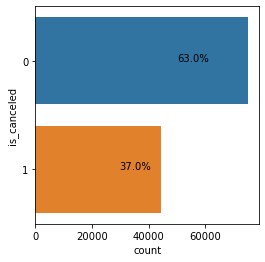

In [12]:
plt.figure(figsize=(4,4))
ax = sns.countplot(y="is_canceled", data=data)
total = len(data['is_canceled'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() / 1.5
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

plt.show()

In [13]:
## separate variables into new data frames
numeric_data = data.select_dtypes(include=[np.number])
cat_data = data.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in train data".format(numeric_data.shape[1],cat_data.shape[1]))

There are 19 numeric and 12 categorical columns in train data


In [14]:
numeric_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.000000,0.370416,0.482918,0.000000,0.000000,0.000000,1.000000,1.000000
lead_time,119390.000000,104.011416,106.863097,0.000000,18.000000,69.000000,160.000000,737.000000
arrival_date_year,119390.000000,2016.156554,0.707476,2015.000000,2016.000000,2016.000000,2017.000000,2017.000000
arrival_date_week_number,119390.000000,27.165173,13.605138,1.000000,16.000000,28.000000,38.000000,53.000000
arrival_date_day_of_month,119390.000000,15.798241,8.780829,1.000000,8.000000,16.000000,23.000000,31.000000
stays_in_weekend_nights,119390.000000,0.927599,0.998613,0.000000,0.000000,1.000000,2.000000,19.000000
stays_in_week_nights,119390.000000,2.500302,1.908286,0.000000,1.000000,2.000000,3.000000,50.000000
adults,119390.000000,1.856403,0.579261,0.000000,2.000000,2.000000,2.000000,55.000000
children,119390.000000,0.103886,0.398555,0.000000,0.000000,0.000000,0.000000,10.000000
babies,119390.000000,0.007949,0.097436,0.000000,0.000000,0.000000,0.000000,10.000000


In [15]:
cat_data.describe().transpose()

,count,unique,top,freq
hotel,119390,2,City Hotel,79330
arrival_date_month,119390,12,August,13877
meal,119390,5,BB,92310
country,118902,177,PRT,48590
market_segment,119390,8,Online TA,56477
distribution_channel,119390,5,TA/TO,97870
reserved_room_type,119390,10,A,85994
assigned_room_type,119390,12,A,74053
deposit_type,119390,3,No Deposit,104641
customer_type,119390,4,Transient,89613


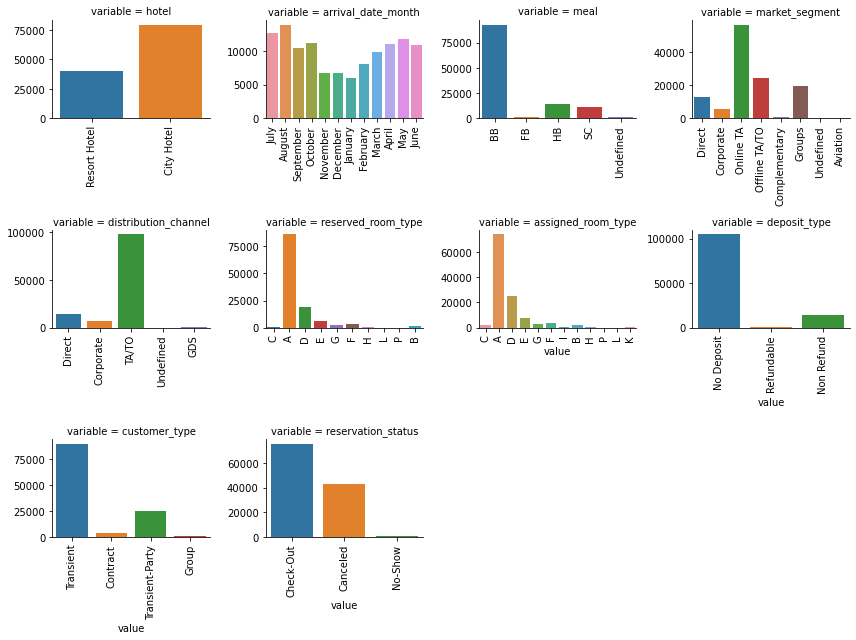

In [16]:
## create count plots
def countplot(x,**kwargs):
    sns.countplot(x=x)
    x = plt.xticks(rotation=90)

cat = [f for f in data.columns if data.dtypes[f] == 'object']
cat.remove('country')
cat.remove('reservation_status_date')
nd = pd.melt(data, value_vars = cat)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey=False)
n1 = n1.map(countplot, 'value')
n1

In [17]:
data['country'].nunique()

177

In [18]:
data['country'].unique()

array(['PRT', 'GBR', 'USA', 'ESP', 'IRL', 'FRA', nan, 'ROU', 'NOR', 'OMN',
       'ARG', 'POL', 'DEU', 'BEL', 'CHE', 'CN', 'GRC', 'ITA', 'NLD',
       'DNK', 'RUS', 'SWE', 'AUS', 'EST', 'CZE', 'BRA', 'FIN', 'MOZ',
       'BWA', 'LUX', 'SVN', 'ALB', 'IND', 'CHN', 'MEX', 'MAR', 'UKR',
       'SMR', 'LVA', 'PRI', 'SRB', 'CHL', 'AUT', 'BLR', 'LTU', 'TUR',
       'ZAF', 'AGO', 'ISR', 'CYM', 'ZMB', 'CPV', 'ZWE', 'DZA', 'KOR',
       'CRI', 'HUN', 'ARE', 'TUN', 'JAM', 'HRV', 'HKG', 'IRN', 'GEO',
       'AND', 'GIB', 'URY', 'JEY', 'CAF', 'CYP', 'COL', 'GGY', 'KWT',
       'NGA', 'MDV', 'VEN', 'SVK', 'FJI', 'KAZ', 'PAK', 'IDN', 'LBN',
       'PHL', 'SEN', 'SYC', 'AZE', 'BHR', 'NZL', 'THA', 'DOM', 'MKD',
       'MYS', 'ARM', 'JPN', 'LKA', 'CUB', 'CMR', 'BIH', 'MUS', 'COM',
       'SUR', 'UGA', 'BGR', 'CIV', 'JOR', 'SYR', 'SGP', 'BDI', 'SAU',
       'VNM', 'PLW', 'QAT', 'EGY', 'PER', 'MLT', 'MWI', 'ECU', 'MDG',
       'ISL', 'UZB', 'NPL', 'BHS', 'MAC', 'TGO', 'TWN', 'DJI', 'STP',
       'KNA', 'E

In [19]:
data['country'] = data['country'].fillna('none')

In [20]:
def cancel_plot(x,y):
    df = data.groupby(x)[y].value_counts(normalize=True)
    df = df.mul(100)
    df = df.rename('percent').reset_index()

    g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df)
    g.ax.set_ylim(0,100)

    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)

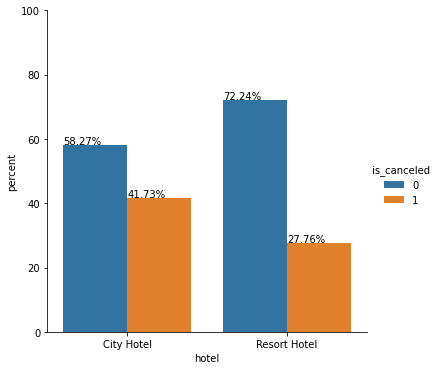

In [21]:
##Hotel
cancel_plot('hotel', 'is_canceled')

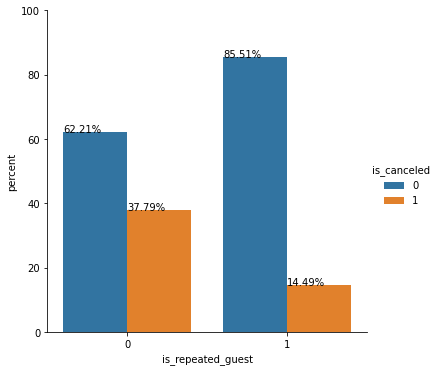

In [22]:
##Repeat Guests
cancel_plot('is_repeated_guest', 'is_canceled')

In [23]:
e = data[['hotel', 'arrival_date_month', 'total_guests']].groupby(['hotel','arrival_date_month']).agg(['count'])
e =  pd.pivot_table(e, values = 'total_guests', index = ['arrival_date_month'], columns = ['hotel'], aggfunc = np.sum, fill_value = 0)
e = e.reset_index()
e

arrival_date_month      count             
hotel                    City Hotel Resort Hotel
0                  April       7480         3609
1                 August       8983         4894
2               December       4132         2648
3               February       4965         3103
4                January       3736         2193
5                   July       8088         4573
6                   June       7894         3045
7                  March       6458         3336
8                    May       8232         3559
9               November       4357         2437
10               October       7605         3555
11             September       7400         3108

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

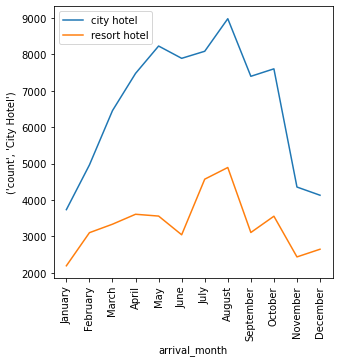

In [24]:
##Total Guests
plt.figure(figsize=(5,5))
ordered_months = ["January", "February", "March", "April", "May", "June", "July",
                  "August", "September", "October", "November", "December"]
e["arrival_month"] = pd.Categorical(e["arrival_date_month"], categories=ordered_months, ordered=True)
sns.lineplot(x='arrival_month',y=('count','City Hotel'),data=e,label='city hotel')
sns.lineplot(x='arrival_month',y=('count','Resort Hotel'),data=e,label='resort hotel')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

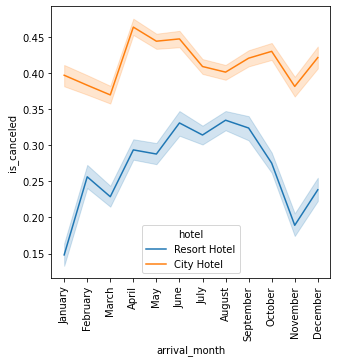

In [25]:
##monthly cancellation rate
plt.figure(figsize=(5,5))
ordered_months = ["January", "February", "March", "April", "May", "June", "July",
                  "August", "September", "October", "November", "December"]
data["arrival_month"] = pd.Categorical(data["arrival_date_month"], categories=ordered_months, ordered=True)
sns.lineplot(x='arrival_month',y='is_canceled',data=data,hue='hotel')
plt.xticks(rotation=90)

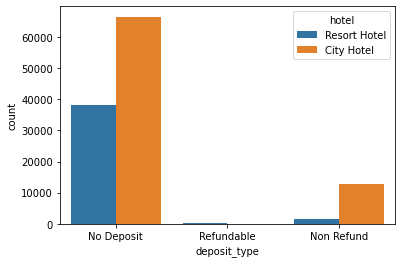

In [26]:
##deposit type count
sns.countplot(x = "deposit_type", hue = "hotel", data = data)

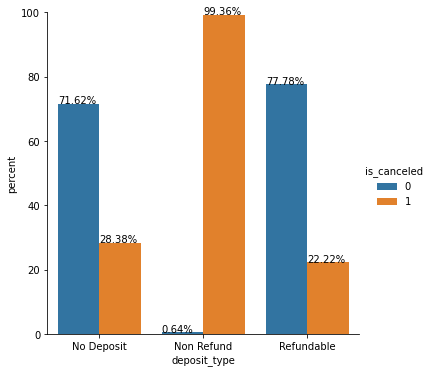

In [27]:
##Non-Refund ==> most cancellations??
cancel_plot('deposit_type', 'is_canceled')

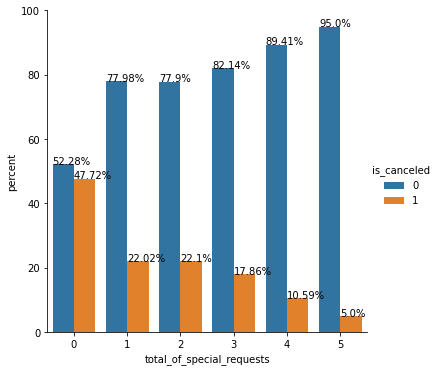

In [28]:
##total special requests
cancel_plot("total_of_special_requests","is_canceled")

posx and posy should be finite values
posx and posy should be finite values


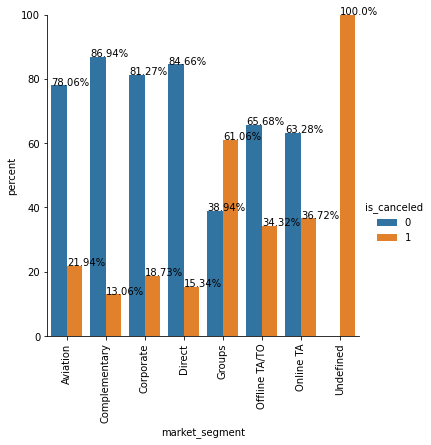

In [29]:
x='market_segment'
y='is_canceled'
df = data.groupby(x)[y].value_counts(normalize=True)
df = df.mul(100)
df = df.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df)
g.ax.set_ylim(0,100)
x = plt.xticks(rotation=90)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

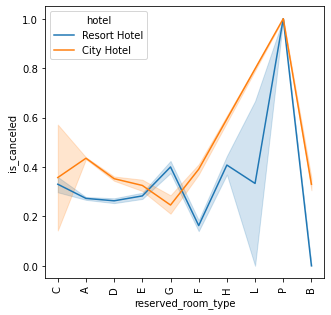

In [30]:
##reserved room 
plt.figure(figsize=(5,5))
sns.lineplot(x='reserved_room_type',y='is_canceled',data=data,hue='hotel')
plt.xticks(rotation=90)

([0, 1, 2, 3], <a list of 4 Text major ticklabel objects>)

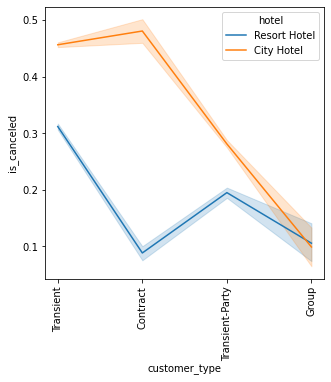

In [31]:
##customer type
plt.figure(figsize=(5,5))
sns.lineplot(x='customer_type',y='is_canceled',data=data,hue='hotel')
plt.xticks(rotation=90)

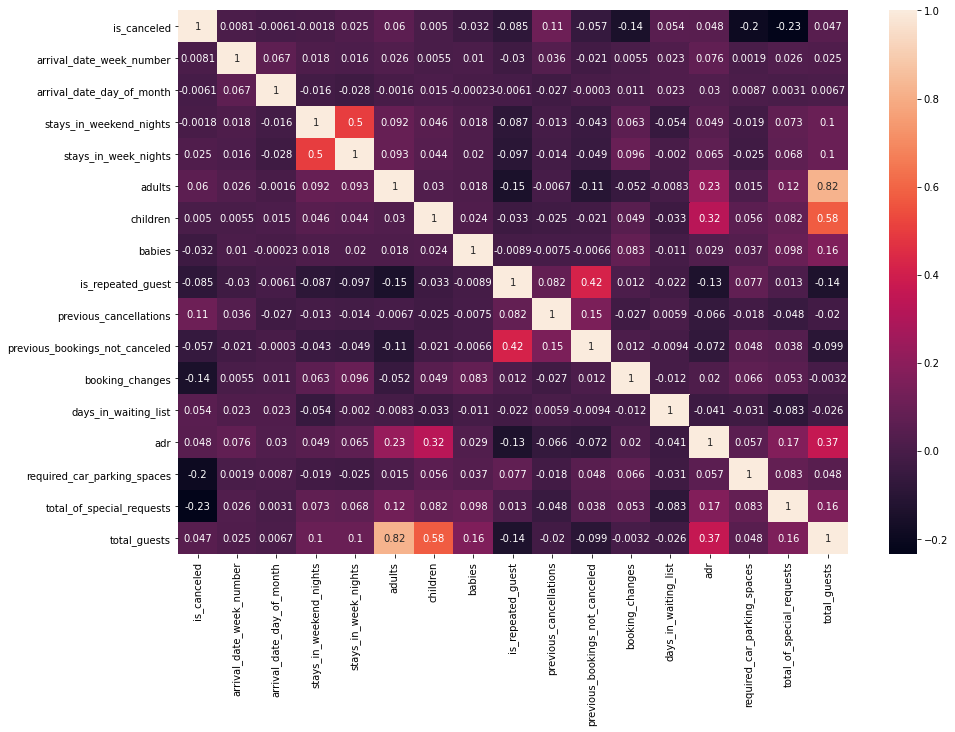

In [32]:
## correlation plot
fig, ax = plt.subplots(figsize=(15,10))
del numeric_data['arrival_date_year']
del numeric_data['lead_time']
corr = numeric_data.corr()
sns.heatmap(corr, annot=True)

In [33]:
## Highly correlated
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print('Correlated features: ', to_drop)

Correlated features:  ['total_guests']


In [34]:
print(corr['is_canceled'].sort_values(ascending=False), '\n') 

is_canceled                       1.000000
previous_cancellations            0.110133
adults                            0.060017
days_in_waiting_list              0.054186
adr                               0.047557
total_guests                      0.046522
stays_in_week_nights              0.024765
arrival_date_week_number          0.008148
children                          0.005036
stays_in_weekend_nights          -0.001791
arrival_date_day_of_month        -0.006130
babies                           -0.032491
previous_bookings_not_canceled   -0.057358
is_repeated_guest                -0.084793
booking_changes                  -0.144381
required_car_parking_spaces      -0.195498
total_of_special_requests        -0.234658
Name: is_canceled, dtype: float64 



                   features     pval  disparity
0                     hotel 0.000000        inf
4            market_segment 0.000000        inf
5      distribution_channel 0.000000        inf
7        assigned_room_type 0.000000        inf
8              deposit_type 0.000000        inf
9             customer_type 0.000000        inf
10       reservation_status 0.000000        inf
11  reservation_status_date 0.000000        inf
6        reserved_room_type 0.000000 306.983772
1        arrival_date_month 0.000000 273.405679
2                      meal 0.000000 147.274689
3                   country      NaN        NaN


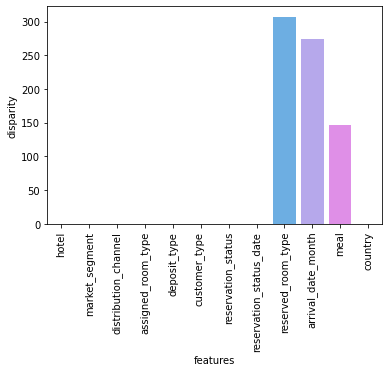

In [35]:
del data['arrival_month']
cat = [f for f in data.columns if data.dtypes[f] == 'object']

## ANOVA test to understand the correlation between categorical variables and cancellation rate. 
## Ho - There exists no significant difference between the groups. 
## Ha - There exists a significant difference between the groups.
## Higher the disparity score, better the feature in prediction. 
def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = cat
    pvals = []
    for c in cat:
        samples = []
        for cls in frame[c].unique():
                s = frame[frame[c] == cls]['is_canceled'].values
                samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

cat_data['is_canceled'] = data.is_canceled.values
k = anova(cat_data) 
k['disparity'] = np.log(1/k['pval'].values)
print(k)
sns.barplot(data=k, x='features', y='disparity') 
plt.xticks(rotation=90) 
plt.show()

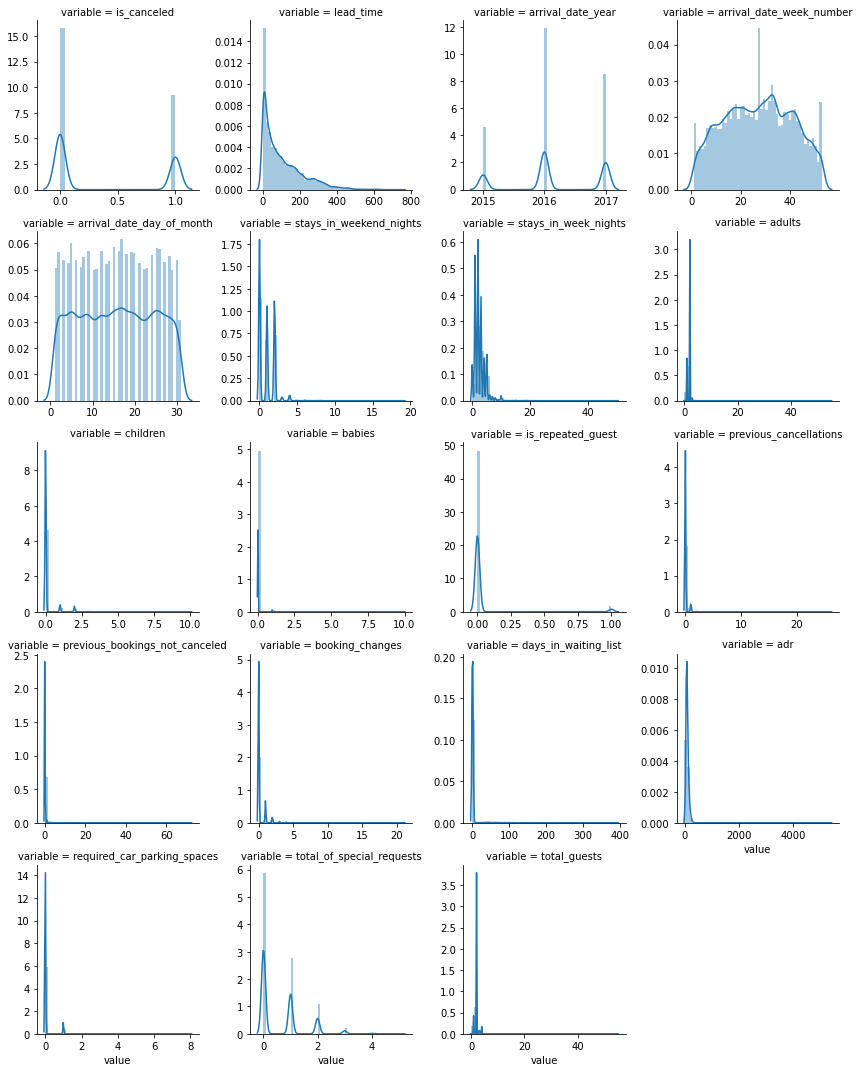

In [36]:
## create numeric plots
num = [f for f in data.columns if data.dtypes[f] != 'object']
nd = pd.melt(data, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

posx and posy should be finite values
posx and posy should be finite values


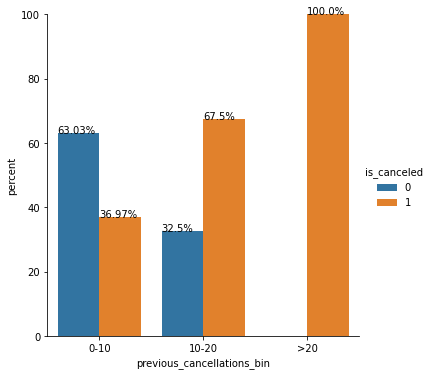

In [37]:
##previous cancellations
data['previous_cancellations_bin'] = np.where(data['previous_cancellations'] < 10, '0-10', np.where((data['previous_cancellations'] >= 10) & (data['previous_cancellations'] < 20), '10-20', np.where((data['previous_cancellations'] >= 20), '>20', '0')))
cancel_plot('previous_cancellations_bin','is_canceled')
del data['previous_cancellations_bin']

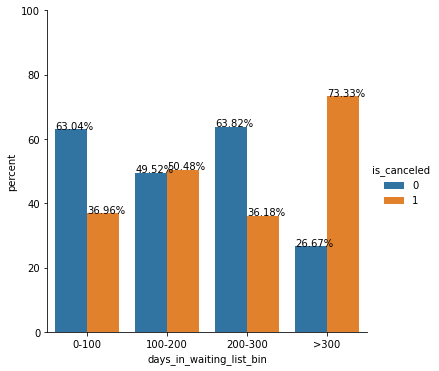

In [38]:
## days in waiting
data['days_in_waiting_list_bin'] = np.where(data['days_in_waiting_list'] < 100, '0-100', np.where((data['days_in_waiting_list'] >= 100) & (data['days_in_waiting_list'] < 200), '100-200', np.where((data['days_in_waiting_list'] >= 200) & (data['days_in_waiting_list'] < 300), '200-300', '>300')))
cancel_plot('days_in_waiting_list_bin','is_canceled')
del data['days_in_waiting_list_bin']

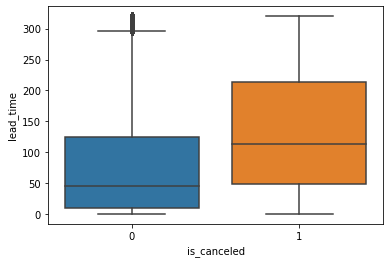

In [39]:
##time 
percentiles = data['lead_time'].quantile([0.05,0.95]).values
data['lead_time'][data['lead_time'] <= percentiles[0]] = percentiles[0]
data['lead_time'][data['lead_time'] >= percentiles[1]] = percentiles[1]
sns.boxplot(y = 'lead_time', x = 'is_canceled', data = data)

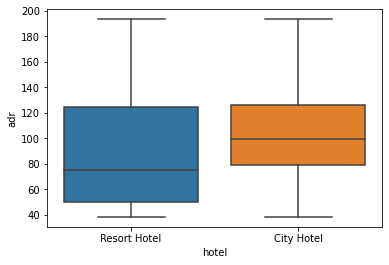

In [40]:
##adr: average daily rate
percentiles = data['adr'].quantile([0.05,0.95]).values
data['adr'][data['adr'] <= percentiles[0]] = percentiles[0]
data['adr'][data['adr'] >= percentiles[1]] = percentiles[1]
sns.boxplot(y = 'adr', x = 'hotel', data = data)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

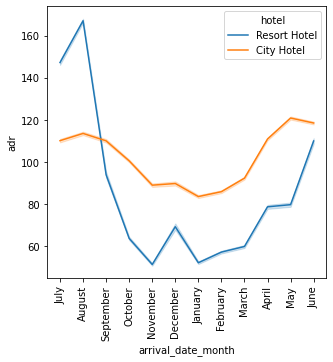

In [41]:
plt.figure(figsize=(5,5))
sns.lineplot(x='arrival_date_month',y='adr',data=data,hue='hotel')
plt.xticks(rotation=90)

In [42]:
##Drop variables: Reservation Status, arrival_date_week_number, arrival_date_day_of_month,
##reservation_status_date, assigned_room_type

In [43]:
X = data.drop(['is_canceled', 'reservation_status', 'arrival_date_week_number', 'arrival_date_day_of_month', 'reservation_status_date', 'assigned_room_type', 'total_guests', 'deposit_type'], axis = 1)
final_iv, IV = woe.data_vars(X, data['is_canceled'])
final_iv['exp_woe'] = np.exp(final_iv['WOE'])
final_iv.head()
final_iv.to_csv('final_iv.csv', index = False)

In [44]:
IV.sort_values(['IV'], ascending = False)

,VAR_NAME,IV
7,country,0.589191
13,lead_time,0.566429
14,market_segment,0.328467
10,distribution_channel,0.156327
8,customer_type,0.087284
11,hotel,0.083066
22,total_of_special_requests,0.080455
16,previous_bookings_not_canceled,0.053044
9,days_in_waiting_list,0.040530
12,is_repeated_guest,0.039400


In [45]:
data = data.drop(['reservation_status', 'arrival_date_week_number', 'arrival_date_day_of_month', 'reservation_status_date', 'arrival_date_year', 'assigned_room_type', 'total_guests', 'deposit_type'], axis = 1)
data.to_csv('train_data.csv', index=False)